In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

In [2]:
from tqdm.notebook import tqdm

In [3]:
path = './Normal videos/Normal_Videos_345_x264.mp4'

In [77]:
video_file = cv2.VideoCapture(path)
print(video_file)

<VideoCapture 0x7fabe9626af0>


In [4]:
if not video_file.isOpened():
    print('Error reading video')

In [5]:

# Getting the frames per second
fps = video_file.get(cv2.CAP_PROP_FPS)

print("Frames per second:", fps)

Frames per second: 30.0


## Saving files

In [9]:
normal_frames_directory = './normal_frames'
# os.makedirs(normal_frames_directory, exist_ok=True)

In [116]:
# video_file = cv2.VideoCapture(path)
# print(video_file)

<VideoCapture 0x7fecc1568950>


In [24]:
#Script to delete files

files_in_directory = os.listdir(normal_frames_directory)
for file in files_in_directory:
    file_path = os.path.join(normal_frames_directory, file)
    # print(file_path)
    
    # remove (delete) the file
    if file_path != './normal_frames/.ipynb_checkpoints':
        # print('yes')
        os.remove(file_path)


## Modular Approach

In [3]:
# video_file = cv2.VideoCapture(path)
# print(video_file)

<VideoCapture 0x7fecc17f0310>


In [25]:
def get_threshold_frames(threshold, difference_dict):
    significant_changes = []

    for key, value in difference_dict.items():
        mean_difference = np.mean(value)
        # print(mean_difference)

        if mean_difference > threshold:
            significant_changes.append(key)
    
    return significant_changes
    

In [26]:
def get_significant_average_frame_keys(key_list):
    
    average_keys_with_significant_changes = set()
    for key in key_list:
        average_keys_with_significant_changes.add(key)
        average_keys_with_significant_changes.add(key + 1)
    return average_keys_with_significant_changes
    

In [27]:
def get_frame_number_from_average_dict_key(key):
    end_frame_number = key * 30
    begin_frame_number = (end_frame_number - 30) + 1
    return begin_frame_number, end_frame_number

In [28]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [29]:
def get_frames_in_range(begin, end):
    indexes = []
    for i in range(begin, end + 1):
        indexes.append(i)
    return indexes

In [30]:
def populate_normal_frames_from_frame_number(frame_numbers_list, original_frames_dict):
    original_frames = []
    for number in frame_numbers_list:
        original_frames.append(original_frames_dict[number])
    
    return original_frames

In [31]:
def get_original_frame_numbers(average_image_keys):
    frame_numbers_list = []
    for key in average_image_keys:
        begin_index, end_index = get_frame_number_from_average_dict_key(key)
        frame_numbers = get_frames_in_range(begin_index, end_index)
        frame_numbers_list.extend(frame_numbers)
    return frame_numbers_list
    

In [32]:
def get_difference_dict(average_frames_dict):
    
    difference_frames_dict = {}
    for i in range(1, len(average_frames_dict)):
        difference = average_frames_dict[i] -  average_frames_dict[i + 1]
        difference_frames_dict[i] = difference
    return difference_frames_dict


In [33]:
# original_frames_dict = {}
# average_frames_dict = {}
# difference_frames_dict = {}

In [34]:
def get_video_change_frames(video_file):
    
    original_frames_dict = {}
    average_frames_dict = {}
    difference_frames_dict = {}
    
    frame_sum = None
    average_frames = []
    seconds_counter = 0
    frame_counter = 0
    total_frames = 0

    while True:
        ret, frame = video_file.read()

        #If the end of frames or any error in reading
        if not ret:
            break

        total_frames += 1

        original_frames_dict[total_frames] = frame

        #converting to grayscale
        image = convert_to_gray(frame)

        #Summing frames for averaging later
        if frame_sum is None:
            frame_sum = image.astype('float64')
        else:
            frame_sum += image.astype('float64')

        frame_counter += 1

        if frame_counter == 30:
            seconds_counter += 1
            average_frame = frame_sum / frame_counter
            average_frames_dict[seconds_counter] = average_frame
            average_frames.append(average_frame)
            frame_sum = None
            frame_counter = 0

    video_file.release()
    cv2.destroyAllWindows()
    
    difference_frames_dict = get_difference_dict(average_frames_dict)
    
    difference_keys_with_significant_changes = get_threshold_frames(0.05, difference_frames_dict)
    
    average_keys_with_significant_changes = \
    get_significant_average_frame_keys(difference_keys_with_significant_changes)
    
    frame_numbers_to_consider = \
    get_original_frame_numbers(average_keys_with_significant_changes)
    
    normal_frames_for_training = \
    populate_normal_frames_from_frame_number(frame_numbers_to_consider, original_frames_dict)
    
    return normal_frames_for_training
    
        

In [35]:
def populate_training_dataset():
    
    training_dataset = []
    
    normal_videos_path = './Normal videos'

    files_in_directory = os.listdir(normal_videos_path)
    for file in tqdm(files_in_directory, desc = 'Reading Normal Videos'):
        file_path = os.path.join(normal_videos_path, file)

        #Reading Video
        if file_path == './Normal videos/.ipynb_checkpoints':
            continue
        video_file = cv2.VideoCapture(file_path)
        frames_from_video = get_video_change_frames(video_file)
        training_dataset.extend(frames_from_video)
    
    return training_dataset

In [36]:
training_frames_dataset = populate_training_dataset()

Reading Normal Videos:   0%|          | 0/26 [00:00<?, ?it/s]

In [37]:
print(len(training_frames_dataset))

42210


### Saving Original Frames for Training

In [3]:
normal_frames_directory = './normal_frames'
os.makedirs(normal_frames_directory, exist_ok=True)

In [39]:
count = 0
for frame in tqdm(training_frames_dataset, desc = 'Saving original frames'):
    count += 1
    cv2.imwrite(f'{normal_frames_directory}/frame_{count}.png', frame)
     

Saving original frames:   0%|          | 0/42210 [00:00<?, ?it/s]

**Using Average Technique**

In [92]:
video_file = cv2.VideoCapture(path)
print(video_file)

<VideoCapture 0x7fecc131d190>


In [215]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [94]:
original_frames = []

In [95]:
frame_sum = None
average_frames = []
frame_counter = 0
total_frames = 0

while True:
    ret, frame = video_file.read()
    
    #If the end of frames or any error in reading
    if not ret:
        break
    
    total_frames += 1
    
    original_frames.append(frame)
        
    #converting to grayscale
    image = convert_to_gray(frame)
    
    #Summing frames for averaging later
    if frame_sum is None:
        frame_sum = image.astype('float64')
    else:
        frame_sum += image.astype('float64')
    
    frame_counter += 1
    
    if frame_counter == 30:
        average_frame = frame_sum / frame_counter
        average_frames.append(average_frame)
        frame_sum = None
        frame_counter = 0
     
video_file.release()
cv2.destroyAllWindows()   
    
    
        

In [96]:
print(f'Total frames : {total_frames}')

Total frames : 305


In [97]:
print(len(average_frames))

10


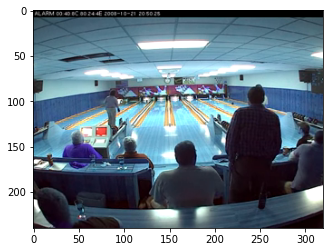

In [98]:
frame_to_display = original_frames[-1]
plt.imshow(frame_to_display)
plt.show()

In [106]:
new_differences_list = []

In [107]:
for i in range(len(average_frames) - 1):
    difference = average_frames[i] -  average_frames[i + 1]
    new_differences_list.append(difference)

In [108]:
print(len(new_differences_list))

9


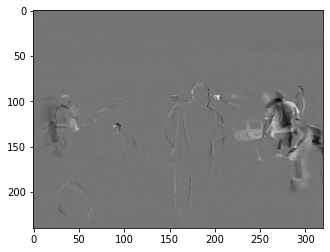

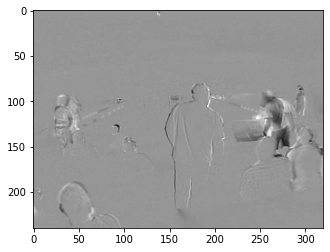

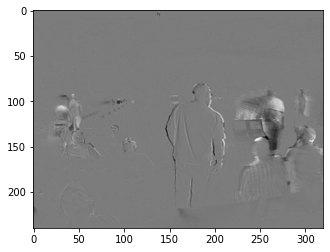

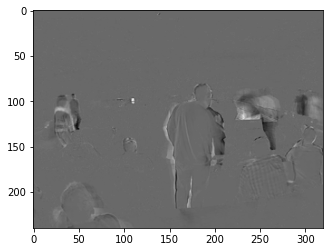

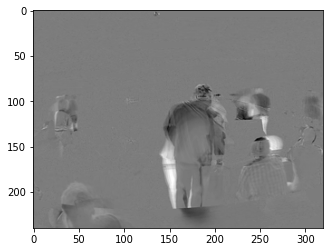

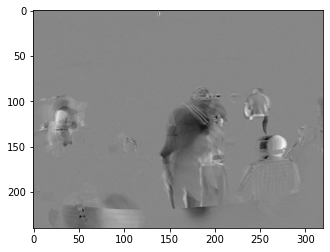

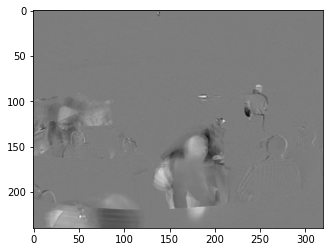

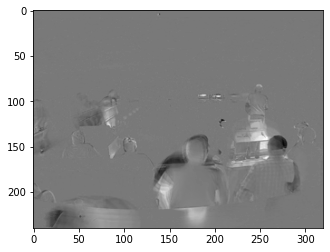

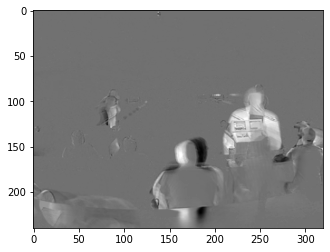

In [109]:
for item in new_differences_list:
    plt.imshow(item, cmap='gray')
    plt.show()

**Thresholding**

In [103]:
threshold = 0.2

significant_changes = []

for i in range(len(new_differences_list)):
    
    mean_difference = np.mean(new_differences_list[i])
    print(mean_difference)
    
    if mean_difference > threshold:
        significant_changes.append(new_differences_list[i])
        
    

0.3599453125
1.0663758680555557
0.7632096354166665
0.3631818576388892
1.5121909722222218
4.925748697916666
-0.19754166666666667
-1.591359375
-5.466342881944445


In [90]:
print(len(significant_changes))

0


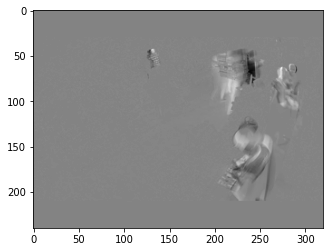

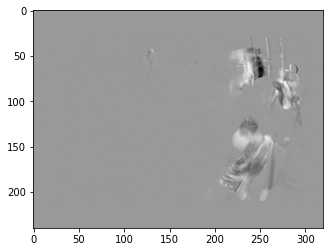

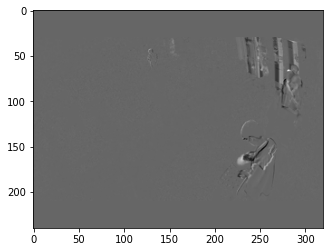

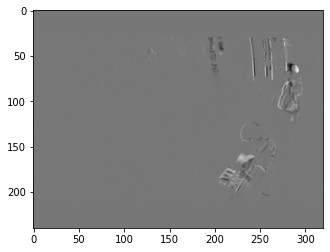

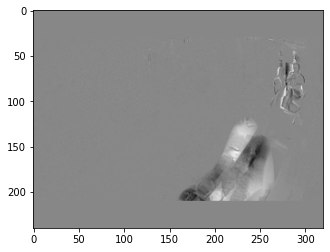

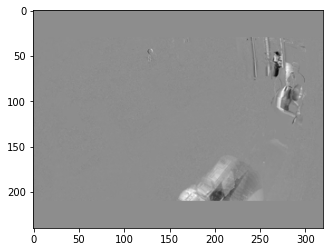

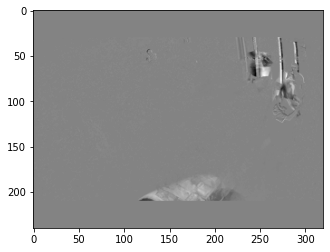

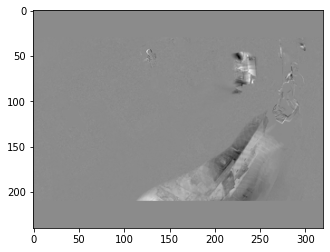

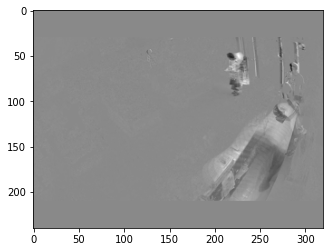

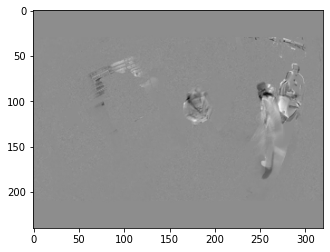

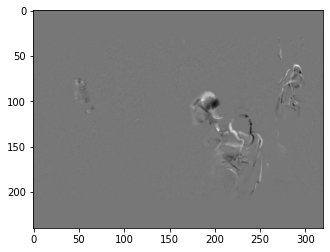

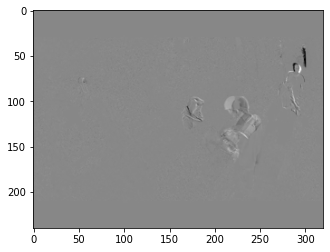

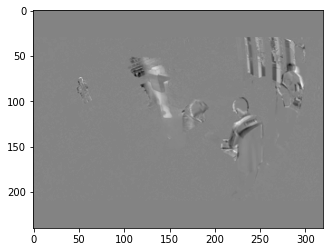

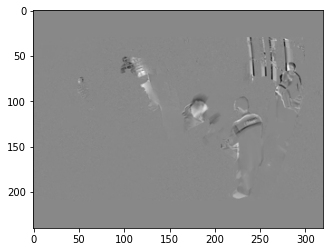

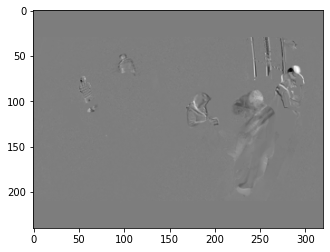

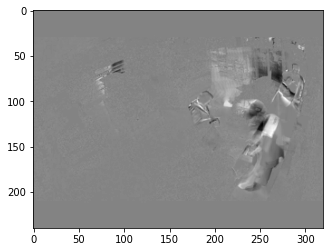

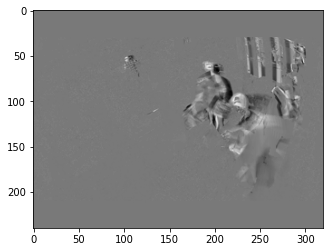

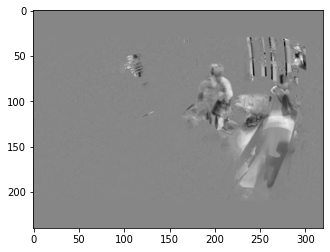

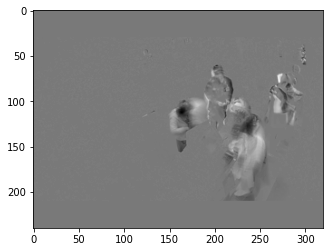

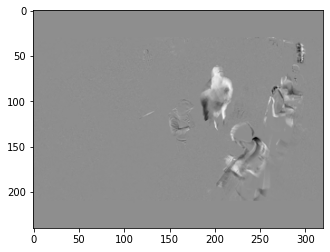

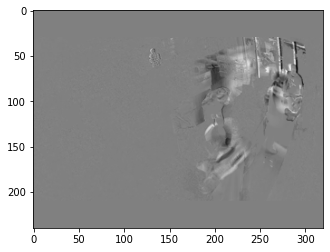

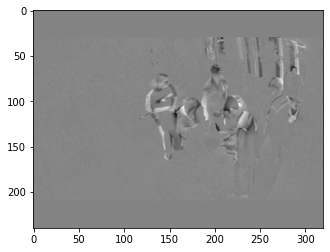

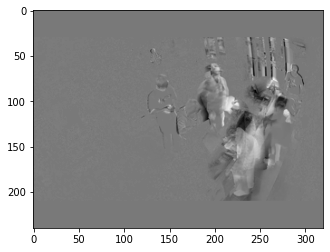

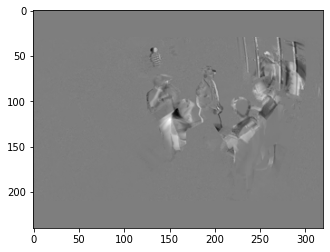

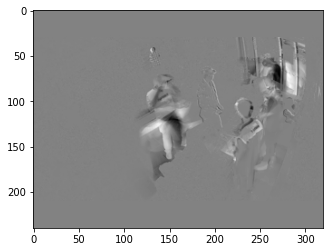

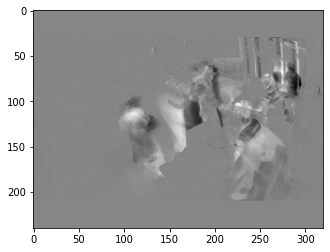

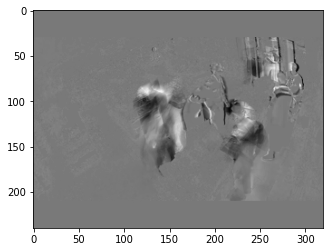

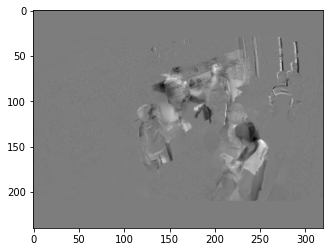

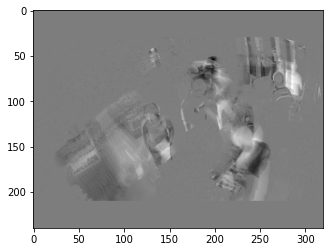

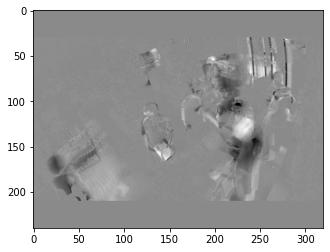

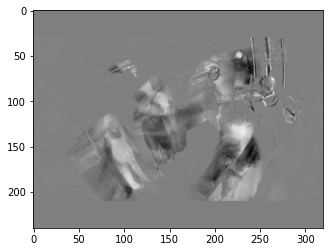

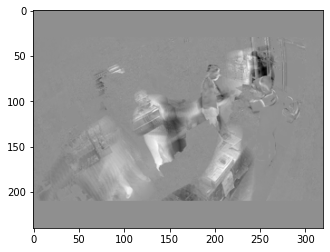

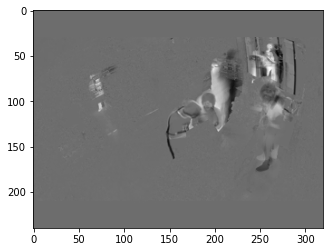

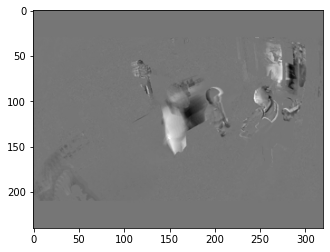

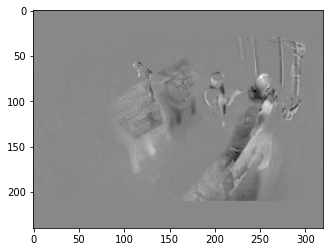

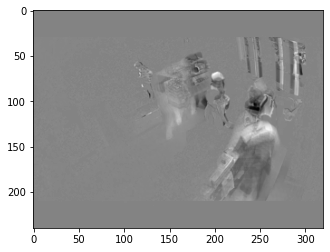

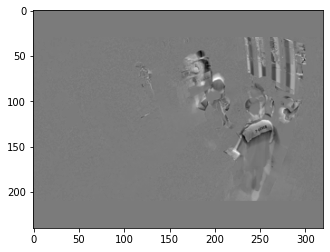

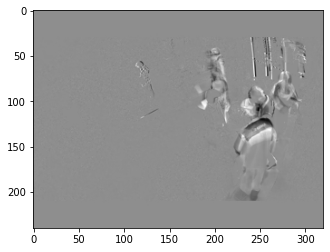

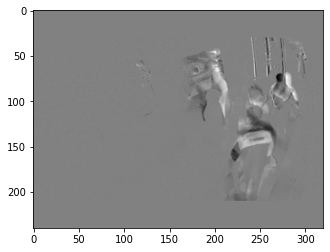

In [76]:
for item in significant_changes:
    plt.imshow(item, cmap='gray')
    plt.show()

## Preprocessing

In [24]:
def display_image(image):
    plt.imshow(image)
    plt.show()

In [76]:
raw_frames_list = []

In [77]:
preprocessed_frames_list = []

In [80]:

files_in_directory = os.listdir(normal_frames_directory)
for file in files_in_directory:
    file_path = os.path.join(normal_frames_directory, file)
    # print(file_path)
    
    # remove (delete) the file
    if file_path != './normal_frames/.ipynb_checkpoints':
        image = cv2.imread(file_path)
        raw_frames_list.append(image)

In [81]:
len(raw_frames_list)

42210

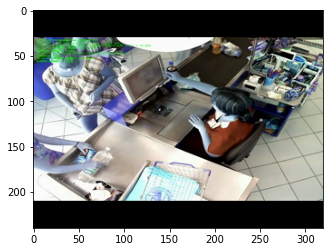

In [83]:
frame_to_process = raw_frames_list[-1]
display_image(frame_to_process)

In [84]:
print(frame_to_process.shape)

(240, 320, 3)


In [31]:
def resize_frame(image):
    resized_image = cv2.resize(image, (224, 224))
    return resized_image
    

In [86]:
#Unit Testing the Resize Function
resized_image = resize_frame(frame_to_process)
print(resized_image.shape)

(224, 224, 3)


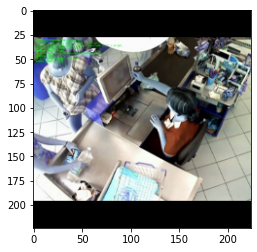

In [87]:
display_image(resized_image)

In [88]:
print(resized_image.shape)

(224, 224, 3)


In [89]:
print(len(preprocessed_frames_list))

0


In [185]:
resized_frames_directory = './resized_images'
os.makedirs(resized_frames_directory, exist_ok=True)

### Resizing all Frames and Saving

In [91]:
count = 0
for frame in tqdm(raw_frames_list):
    resized = resize_frame(frame)
    count+= 1
    cv2.imwrite(f'{resized_frames_directory}/frame_{count}.png', resized)

  0%|          | 0/42210 [00:00<?, ?it/s]

In [73]:
# files_in_directory = os.listdir(resized_frames_directory)
# for file in files_in_directory:
#     file_path = os.path.join(resized_frames_directory, file)
#     # print(file_path)
    
#     # remove (delete) the file
#     if file_path != './resized_images/.ipynb_checkpoints':
#         # print('yes')
#         os.remove(file_path)

In [92]:
len(preprocessed_frames_list)

0

In [181]:
def normalize_frames(frame):
    normalized_frame = np.divide(frame, np.max(frame)).astype(np.float32)
    return normalized_frame
    

In [182]:
resized_images_list = []

In [188]:
normalized_frames_list = []

### Normalizing all frames

In [186]:
files_in_directory = os.listdir(resized_frames_directory)
for file in tqdm(files_in_directory):
    file_path = os.path.join(resized_frames_directory, file)
    # print(file_path)
    
    if file_path != './resized_images/.ipynb_checkpoints':
        image = cv2.imread(file_path)
        resized_images_list.append(image)

  0%|          | 0/42210 [00:00<?, ?it/s]

In [187]:
print(len(resized_images_list))

42210


In [16]:
#Saving Resized Images Numpy List

np.save('resized_image_list.npy', resized_images_list)

In [ ]:
resized_images_list = np.load('resized_image_list.npy').tolist()

In [16]:
print(len(resized_images_list))

42210


In [189]:
for frame in tqdm(resized_images_list):
    normalized_frames_list.append(normalize_frames(frame))

  0%|          | 0/42210 [00:00<?, ?it/s]

/tmp/ipykernel_198483/1873768991.py:2: RuntimeWarning: invalid value encountered in true_divide
  normalized_frame = np.divide(frame, np.max(frame)).astype(np.float32)


In [ ]:
#Saving the Normalized Images

np.save('normalized_image_list.npy', normalized_frames_list)

In [190]:
print(len(normalized_frames_list))

42210


In [191]:
print(np.max(normalized_frames_list[0]))

1.0


## Anomaly Detector

In [192]:
print('Hello')

Hello


In [193]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('accuracy') >= 0.90):
            print('\nReached 90% Accuracy, Stopping Training!')
            self.model.stop_training = True

In [194]:
def autoencoder_model():
    
    #Encoder Logic

    input_image = tf.keras.layers.Input(shape = (224, 224, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(input_image)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding='same')(x)
    encode = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    #Decoder Logic

    x = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding='same')(encode)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    decode = tf.keras.layers.Conv2D(3, (3, 3), activation = 'sigmoid', padding='same')(x)
    
    #Defining Model
    model = tf.keras.models.Model(inputs = input_image, outputs = decode)
    
    
    #Compiling Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
    
    return model

In [195]:
model = autoencoder_model()

In [196]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 128)       7385

In [180]:
from sklearn.model_selection import train_test_split

In [197]:
trial_normalized_images = normalized_frames_list[:8000]
trial_normalized_images = np.array(trial_normalized_images)

In [198]:
print(len(trial_normalized_images))

8000


In [199]:
print(type(trial_normalized_images))

<class 'numpy.ndarray'>


In [200]:
print(len(normalized_frames_list))

42210


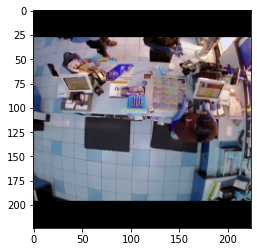

In [201]:
display_image(trial_normalized_images[20])

In [202]:
# normalized_frames_list = np.array(normalized_frames_list)

In [203]:
x_train, x_val = train_test_split(trial_normalized_images, test_size=0.2, random_state=42)

In [204]:
type(x_train)

numpy.ndarray

In [205]:
len(x_train)

6400

In [206]:
callback = myCallback()

In [207]:
callback

In [209]:
history = model.fit(x_train, x_train, epochs = 50, callbacks = [callback], validation_data=(x_val, x_val))

2023-07-24 19:03:45.747011: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3853516800 exceeds 10% of free system memory.
2023-07-24 19:03:57.192861: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB (rounded to 3853516800)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-07-24 19:03:57.192919: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-07-24 19:03:57.192940: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 64, Chunks in use: 63. 16.0KiB allocated for chunks. 15.8KiB in use in bin. 4.7KiB client-requested in use in bin.
2023-07-24 19:03:57.192953: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

e/common_runtime/bfc_allocator.cc:1034] Bin (524288): 	Total Chunks: 6, Chunks in use: 6. 3.73MiB allocated for chunks. 3.73MiB in use in bin. 3.38MiB client-requested in use in bin.
2023-07-24 19:03:57.193088: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (1048576): 	Total Chunks: 1, Chunks in use: 0. 1.12MiB allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-07-24 19:03:57.193099: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (2097152): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-07-24 19:03:57.193109: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (4194304): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-07-24 19:03:57.193120: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (8388608): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in 

In [32]:
model.save('./auto_encoder.keras')

In [59]:
predictions = model.predict(x_train)

25/25 [==============================] - 2s 88ms/step


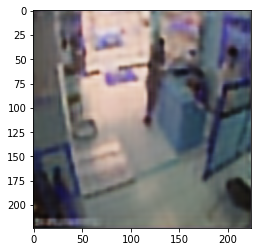

In [63]:
display_image(predictions[0])

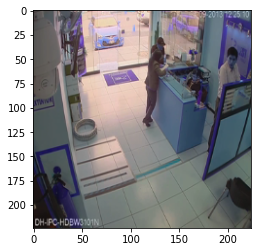

In [64]:
display_image(x_train[0])

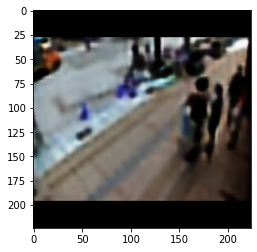

In [70]:
display_image(predictions[100])

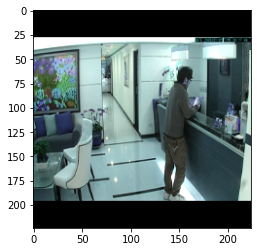

In [68]:
display_image(x_train[25])

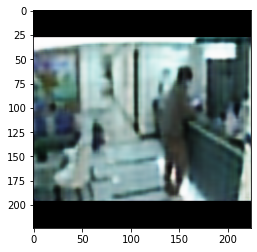

In [69]:
display_image(predictions[25])

In [61]:
mse = tf.keras.losses.MeanSquaredError()
error = mse(x_train[-1], predictions[-1]).numpy()
print(error*255)

1.5530299837701023


In [65]:
error = mse(x_train[0], predictions[0]).numpy()
print(error*255)

0.7715215848293155


In [66]:
error = mse(x_train[50], predictions[50]).numpy()
print(error*255)

0.5061184731312096


In [67]:
error = mse(x_train[25], predictions[25]).numpy()
print(error*255)

1.1760220513679087


In [8]:
test_model = tf.keras.models.load_model('./auto_encoder.keras')

In [50]:
trial_data = np.expand_dims(x_train[-1], axis=0)
predictions = model.predict(trial_data)

1/1 [==============================] - 0s 279ms/step


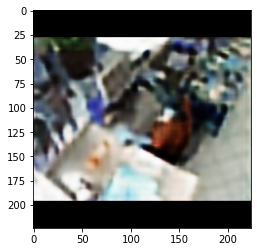

In [55]:
display_image(predictions[0])

## Testing Model

In [52]:
import random
mse = tf.keras.losses.MeanSquaredError()

In [26]:
normal_video_directory = './Normal videos/'
anomaly_video_directory = './Anomaly Videos/'

In [158]:
files_in_normal_directory = os.listdir(normal_video_directory)
files_in_anomaly_directory = os.listdir(anomaly_video_directory)
# for file in files_in_directory:

normal_video_file = random.choice(files_in_normal_directory)
anomaly_video_file = random.choice(files_in_anomaly_directory)

print(normal_video_file,anomaly_video_file)

normal_video_file_path = os.path.join(normal_video_directory, normal_video_file)
anomaly_video_file_path = os.path.join(anomaly_video_directory, anomaly_video_file)
    

Normal_Videos_745_x264.mp4 Arson002_x264.mp4


In [159]:
def get_frames_from_video(video_file_path):
    video_file = cv2.VideoCapture(video_file_path)
    
    total_frames = 0
    original_frames_dict = {}
    
    while True:
        ret, frame = video_file.read()

        #If the end of frames or any error in reading
        if not ret:
            break
            
        total_frames += 1

        original_frames_dict[total_frames] = frame
    
    video_file.release()
    cv2.destroyAllWindows()
    
    return original_frames_dict

In [170]:
normal_video_frame_dict = get_frames_from_video(normal_video_file_path)
test_normal_frame = normal_video_frame_dict[200]

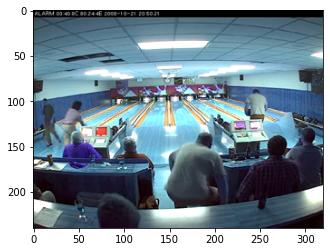

In [171]:
display_image(test_normal_frame)

In [172]:
# test_normal_data = np.expand_dims(test_normal_frame, axis=0)
resized_frame = resize_frame(test_normal_frame)
normalized_frame = normalize_frames(resized_frame)
dim_expanded = np.expand_dims(normalized_frame, axis=0)
normal_predictions = test_model.predict(dim_expanded)

1/1 [==============================] - 0s 13ms/step


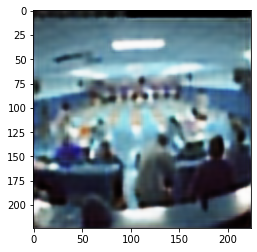

In [173]:
display_image(normal_predictions[0])

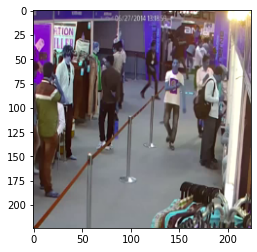

In [78]:
display_image(normalized_frame)

In [79]:
error1 = mse(normalized_frame, normal_predictions[0]).numpy()
print(error*255)

1.744297945406288


In [93]:
error2 = mse(normalized_frame, normal_predictions[0]).numpy()
print(error2*255)

23.821472749114037


In [149]:
anomaly_video_frame_dict = get_frames_from_video(anomaly_video_file_path)
test_anomaly_frame = anomaly_video_frame_dict[3000]

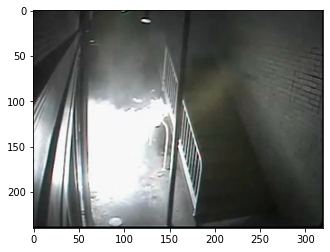

In [150]:
display_image(test_anomaly_frame)

In [152]:
# test_normal_data = np.expand_dims(test_normal_frame, axis=0)
resized_frame = resize_frame(test_anomaly_frame)
normalized_frame = normalize_frames(resized_frame)
dim_expanded = np.expand_dims(normalized_frame, axis=0)
anomaly_predictions = test_model.predict(dim_expanded)

1/1 [==============================] - 0s 14ms/step


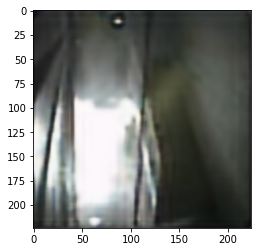

In [153]:
display_image(anomaly_predictions[0])

In [154]:
error3 = mse(normalized_frame, anomaly_predictions[0]).numpy()
print(error3*255)

0.9490778634790331


### SSIM

In [175]:
from skimage.metrics import structural_similarity as ssim

image1 = normalized_frame
image2 = normal_predictions[0]

ssim_value, _ = ssim(image1, image2, full=True, channel_axis = -1)
print("SSIM Score:", ssim_value)

SSIM Score: 0.7738568


## Checking Pretrained Model

In [210]:
pre_trained_model = tf.keras.models.load_model('./model.hdf5')


In [211]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 10, 64, 64, 128)  15616     
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 64, 64, 128)  256       
 rNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 32, 32, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_2 (Laye  (None, 10, 32, 32, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)  

In [263]:
video_file = cv2.VideoCapture(anomaly_video_file_path)

In [264]:
video_file

<VideoCapture 0x7fe318e1c490>

In [266]:
def resize_for_model(image):
    resized_image = cv2.resize(image, (256, 256))
    return resized_image

In [278]:
frames_dict = get_frames_from_video(anomaly_video_file_path)
len(frames_dict)

4439

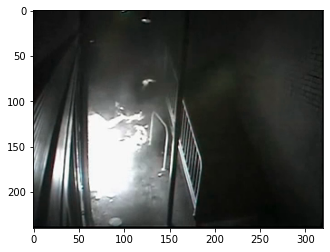

In [282]:
display_image(frames_dict[3012])

In [294]:
test_list = []

In [295]:
for i in range(3000, 3010):
    frame = frames_dict[i]
    resized_image = resize_for_model(frame)
    gray_converted = convert_to_gray(resized_image)
    normalized_image = normalize_frames(gray_converted)
    test_list.append(normalized_image)
    

In [296]:
test_list = np.array(test_list)

In [297]:
test_list = test_list.reshape((1, 10, 256, 256, 1))

In [298]:
len(test_list)

1

In [299]:
reconstructed_sequences = pre_trained_model.predict(test_list)

1/1 [==============================] - 0s 49ms/step


In [300]:
len(reconstructed_sequences)

1

In [301]:
reconstructed_sequences[0].shape

(10, 256, 256, 1)

In [302]:
sequences_reconstruction_cost = np.linalg.norm(np.subtract(test_list,reconstructed_sequences))

In [303]:
sequences_reconstruction_cost

106.11103

In [277]:
sequences_reconstruction_cost

100.34664

In [ ]:
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa